In [1]:
import PIL
from PIL import Image
#from matplotlib import image
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
import tensorflow.keras
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [2]:
%load_ext autoreload
%autoreload 2

In [2]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [6]:
img_gen = ImageDataGenerator(rescale=1./255)

In [7]:
img_size = (300,800)
train_data_gen = img_gen.flow_from_directory(directory='images/train/',
                                                    batch_size=6,
                                                    shuffle=True,
                                                    target_size= img_size,
                                                    class_mode='binary',
                                                    classes=['non_PL','PL'])
test_data_gen = img_gen.flow_from_directory(directory='images/test/',
                                                   batch_size=6,
                                                   shuffle=True,
                                                   target_size= img_size,
                                                   class_mode='binary',
                                                   classes=['non_PL','PL'])
predict_PL_gen = img_gen.flow_from_directory(directory='images/predict/PL',
                                                      target_size= img_size,
                                                      batch_size=6,
                                                      class_mode='binary',
                                                      classes=['PL'])
predict_non_PL_gen = img_gen.flow_from_directory(directory='images/predict/non_PL',
                                                      target_size= img_size,
                                                      batch_size=6,
                                                      class_mode='binary',
                                                      classes=['non_PL'])                                

Found 3910 images belonging to 2 classes.
Found 720 images belonging to 2 classes.
Found 100 images belonging to 1 classes.
Found 100 images belonging to 1 classes.


In [17]:
# import and configure model checkpoints
import os
checkpoint_prefix = os.path.join('model_checkpoints/', "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)


In [3]:
base_full_res = keras.Sequential()
base_full_res.add(keras.layers.Conv2D(128,(4,4), padding='same', activation='relu', input_shape=(300,800,3)))
base_full_res.add(keras.layers.MaxPooling2D((6,6)))
base_full_res.add(keras.layers.Dense(128))
base_full_res.add(keras.layers.Conv2D(122,(2,2), activation='relu'))
base_full_res.add(keras.layers.MaxPooling2D((2,2)))
base_full_res.add(keras.layers.Flatten())
base_full_res.add(keras.layers.Dense(64))    
base_full_res.add(keras.layers.Dense(1, activation='sigmoid'))

base_full_res.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

In [4]:
base_full_res.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 300, 800, 128)     6272      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 133, 128)      0         
_________________________________________________________________
dense (Dense)                (None, 50, 133, 128)      16512     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 49, 132, 122)      62586     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 66, 122)       0         
_________________________________________________________________
flatten (Flatten)            (None, 193248)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                1

In [8]:
base1 = base_full_res.fit(train_data_gen, epochs=20,
                    validation_data=(test_data_gen)
                   )

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 652 steps, validate for 120 steps
Epoch 1/20
652/652 [==============================] - 207s 317ms/step - loss: 0.7815 - accuracy: 0.6123 - val_loss: 0.6618 - val_accuracy: 0.5542
Epoch 2/20
652/652 [==============================] - 175s 269ms/step - loss: 0.6946 - accuracy: 0.5604 - val_loss: 0.6865 - val_accuracy: 0.5556
Epoch 3/20
652/652 [==============================] - 176s 269ms/step - loss: 0.7020 - accuracy: 0.5606 - val_loss: 0.6870 - val_accuracy: 0.5556
Epoch 4/20
652/652 [==============================] - 175s 269ms/step - loss: 0.6868 - accuracy: 0.5619 - val_loss: 0.6870 - val_accuracy: 0.5556
Epoch 5/20
652/652 [==============================] - 175s 269ms/step - loss: 0.6862 - accuracy: 0.5596 - val_loss: 0.6883 - val_accuracy: 0.5556
Epoch 6/20
652/652 [==============================] - 175s 269ms/step - loss: 0.6863 - accuracy: 0.5596 - val_loss: 0.6870 - val_accuracy: 0.5556
Epoch 7/20
652/652 [==========

In [5]:
# install hub to docker image for transfer learning
!pip install --upgrade tensorflow-hub

     |################################| 89 kB 725 kB/s eta 0:00:01


In [3]:
import tensorflow_hub as hub

In [4]:
# build resnet model
m = tf.keras.Sequential([
          hub.KerasLayer("https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4",
          trainable=False),
          tf.keras.layers.Dense(128, activation='relu'),
          tf.keras.layers.Dense(64, activation='relu'),
          tf.keras.layers.Dense(1, activation='sigmoid')
])
m.compile(optimizer='adam',
             loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
             metrics=['accuracy'])

m.build([6, 224, 224, 3])  # Batch input shape.


In [8]:
m.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     multiple                  23564800  
_________________________________________________________________
dense (Dense)                multiple                  262272    
_________________________________________________________________
dense_1 (Dense)              multiple                  8256      
_________________________________________________________________
dense_2 (Dense)              multiple                  65        
Total params: 23,835,393
Trainable params: 270,593
Non-trainable params: 23,564,800
_________________________________________________________________


In [8]:
# Trained with one 64 node Dense layer before output

RN_D = m.fit(train_data_gen, epochs=20,
                    validation_data=(test_data_gen),
                    #callbacks=[checkpoint_callback]
                   )

  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 652 steps, validate for 120 steps
Epoch 1/20
652/652 [==============================] - 134s 206ms/step - loss: 0.4444 - accuracy: 0.7977 - val_loss: 0.4581 - val_accuracy: 0.7833
Epoch 2/20
652/652 [==============================] - 121s 186ms/step - loss: 0.2856 - accuracy: 0.8788 - val_loss: 0.3933 - val_accuracy: 0.8236
Epoch 3/20
652/652 [==============================] - 122s 187ms/step - loss: 0.1899 - accuracy: 0.9192 - val_loss: 0.3378 - val_accuracy: 0.8556
Epoch 4/20
652/652 [==============================] - 121s 186ms/step - loss: 0.1144 - accuracy: 0.9619 - val_loss: 0.3891 - val_accuracy: 0.8667
Epoch 5/20
652/652 [==============================] - 121s 185ms/step - loss: 0.0699 - accuracy: 0.9754 - val_loss: 0.4283 - val_accuracy: 0.8708
Epoch 6/20
652/652 [==============================] - 121s 186ms/step - loss: 0.0360 - accuracy: 0.9905 - val_loss: 0.5309 - val_accuracy: 0.8653
Epoch 7/20
652/652 [==============================] - 121s 186ms/step - loss: 0.

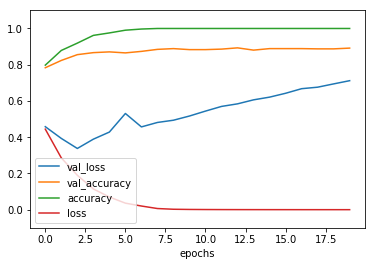

In [10]:
for key, value in RN_D.history.items():
    plt.plot(value, label=key)
    plt.ylim(-.1,1.1)
    plt.legend()
    plt.xlabel('epochs')

In [9]:
# Trained with 128 and 64 node Dense layers before output

RN_D2 = m.fit(train_data_gen, epochs=20,
                    validation_data=(test_data_gen),
                    #callbacks=[checkpoint_callback]
                   )

  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 652 steps, validate for 120 steps
Epoch 1/20
652/652 [==============================] - 246s 377ms/step - loss: 0.3790 - accuracy: 0.8330 - val_loss: 0.2931 - val_accuracy: 0.8736
Epoch 2/20
652/652 [==============================] - 153s 235ms/step - loss: 0.2332 - accuracy: 0.9015 - val_loss: 0.3452 - val_accuracy: 0.8542
Epoch 3/20
652/652 [==============================] - 156s 239ms/step - loss: 0.1620 - accuracy: 0.9338 - val_loss: 0.2888 - val_accuracy: 0.8903
Epoch 4/20
652/652 [==============================] - 157s 240ms/step - loss: 0.1003 - accuracy: 0.9624 - val_loss: 0.2477 - val_accuracy: 0.9069
Epoch 5/20
652/652 [==============================] - 158s 242ms/step - loss: 0.0833 - accuracy: 0.9691 - val_loss: 0.3168 - val_accuracy: 0.9125
Epoch 6/20
652/652 [==============================] - 158s 243ms/step - loss: 0.0567 - accuracy: 0.9788 - val_loss: 0.2376 - val_accuracy: 0.9319
Epoch 7/20
652/652 [==============================] - 159s 243ms/step - loss: 0.

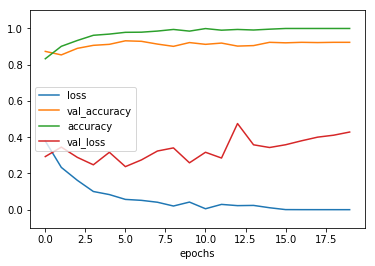

In [10]:
for key, value in RN_D2.history.items():
    plt.plot(value, label=key)
    plt.ylim(-.1,1.1)
    plt.legend()
    plt.xlabel('epochs')

In [11]:
# Predict 200 unseen image labels
PL_predict = m.predict(predict_PL_gen)
non_PL_predict = m.predict(predict_non_PL_gen)

In [12]:
# Grab indexes of misclassified images
PL_indexes = np.nonzero(PL_predict < .5)
non_PL_indexes = np.nonzero(non_PL_predict > .5)

In [49]:
# Round 1 (1 Dense layer)
print(PL_indexes)
print(non_PL_indexes)

(array([ 8, 12, 30, 62, 91]), array([0, 0, 0, 0, 0]))
(array([ 4, 39, 43, 54, 72, 75, 88]), array([0, 0, 0, 0, 0, 0, 0]))


In [13]:
# Round 2 (2 Dense layers))
print(PL_indexes)
print(non_PL_indexes)

(array([71]), array([0]))
(array([31, 66, 76]), array([0, 0, 0]))


In [37]:
# Round 1 Grab directories of misclassified images
PL_directories = list(tf.data.Dataset.list_files('images/predict/PL/' + '*/*'))
non_PL_directories = list(tf.data.Dataset.list_files('images/predict/non_PL/' + '*/*'))

In [47]:
# Round 1 PL
for idx, direct in enumerate(PL_directories):
    if idx in PL_indexes[0]:
        print(direct)
    

tf.Tensor(b'images/predict/PL/PL/2_372.png', shape=(), dtype=string)
tf.Tensor(b'images/predict/PL/PL/2_1134.png', shape=(), dtype=string)
tf.Tensor(b'images/predict/PL/PL/2_1273.png', shape=(), dtype=string)
tf.Tensor(b'images/predict/PL/PL/565.png', shape=(), dtype=string)
tf.Tensor(b'images/predict/PL/PL/2_750.png', shape=(), dtype=string)


In [48]:
# Round 1 non_PL
for idx, direct in enumerate(non_PL_directories):
    if idx in non_PL_indexes[0]:
        print(direct)

tf.Tensor(b'images/predict/non_PL/non_PL/155.png', shape=(), dtype=string)
tf.Tensor(b'images/predict/non_PL/non_PL/677.png', shape=(), dtype=string)
tf.Tensor(b'images/predict/non_PL/non_PL/2_1099.png', shape=(), dtype=string)
tf.Tensor(b'images/predict/non_PL/non_PL/802.png', shape=(), dtype=string)
tf.Tensor(b'images/predict/non_PL/non_PL/729.png', shape=(), dtype=string)
tf.Tensor(b'images/predict/non_PL/non_PL/1100.png', shape=(), dtype=string)
tf.Tensor(b'images/predict/non_PL/non_PL/1301.png', shape=(), dtype=string)


In [14]:
# Round 2 Grab directories of misclassified images
PL_directories = list(tf.data.Dataset.list_files('images/predict/PL/' + '*/*'))
non_PL_directories = list(tf.data.Dataset.list_files('images/predict/non_PL/' + '*/*'))

In [15]:
# Round 2 PL
for idx, direct in enumerate(PL_directories):
    if idx in PL_indexes[0]:
        print(direct)
        
# Round 2 non_PL
for idx, direct in enumerate(non_PL_directories):
    if idx in non_PL_indexes[0]:
        print(direct)       

tf.Tensor(b'images/predict/PL/PL/705.png', shape=(), dtype=string)
tf.Tensor(b'images/predict/non_PL/non_PL/869.png', shape=(), dtype=string)
tf.Tensor(b'images/predict/non_PL/non_PL/776.png', shape=(), dtype=string)
tf.Tensor(b'images/predict/non_PL/non_PL/916.png', shape=(), dtype=string)


In [17]:
# Save model scores
f = open("model_results/resnet2.txt","w")
f.write( str(RN_D2.history) )
f.close()